# Diagnosing Heart Disease
## Using ML Tools and Techniques

<img style="float: left;" src="https://www.aitrends.com/wp-content/uploads/2017/04/4-20AIinHealthcare-2.jpg" width="350px"/>


1. [The Data](#first-bullet)
2. [Preprocessing](#second-bullet)
3. [Creating and Training Models](#second-bullet)
4. [Results](#second-bullet)
5. [Explainability](#second-bullet)
4. [Ensemble Aggregation](#second-bullet)


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn import svm
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.metrics import binary_accuracy
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap
from statistics import mean
#from pdpbox import pdp, info_plots #for partial plots
np.random.seed(229) #ensure reproducibility


/Users/chamling/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
Using TensorFlow backend.


In [3]:
#https://www.kaggle.com/tentotheminus9/what-causes-heart-disease-explaining-the-model

<a id='section2'></a>

# The Data

In [4]:
dt = pd.read_csv("heart.csv")

In [5]:
dt.head(10)

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   3       145   233    1        0      150      0      2.3      0   
1   37    1   2       130   250    0        1      187      0      3.5      0   
2   41    0   1       130   204    0        0      172      0      1.4      2   
3   56    1   1       120   236    0        1      178      0      0.8      2   
4   57    0   0       120   354    0        1      163      1      0.6      2   
5   57    1   0       140   192    0        1      148      0      0.4      1   
6   56    0   1       140   294    0        0      153      0      1.3      1   
7   44    1   1       120   263    0        1      173      0      0.0      2   
8   52    1   2       172   199    1        1      162      0      0.5      2   
9   57    1   2       150   168    0        1      174      0      1.6      2   

   ca  thal  target  
0   0     1       1  
1   0     2       1  
2   0     2       1  
3   0     2       1  
4   0     2       1  
5   0     1       1  
6   0     2       1  
7   0     3       1  
8   0     3       1  
9   0     2       1

It's a clean, easy to understand set of data. However, the meaning of some of the column headers are not obvious. Here's what they mean,

- **age**: The person's age in years
- **sex**: The person's sex (1 = male, 0 = female)
- **cp:** The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- **trestbps:** The person's resting blood pressure (mm Hg on admission to the hospital)
- **chol:** The person's cholesterol measurement in mg/dl
- **fbs:** The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false) 
- **restecg:** Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- **thalach:** The person's maximum heart rate achieved
- **exang:** Exercise induced angina (1 = yes; 0 = no)
- **oldpeak:** ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more [here](https://litfl.com/st-segment-ecg-library/))
- **slope:** the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- **ca:** The number of major vessels (0-3)
- **thal:** A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **target:** Heart disease (0 = no, 1 = yes)


# Preprocessing



In [6]:
#Make the column names readable

dt.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [7]:
#Make some of the variables categorical for clarity

dt['sex'][dt['sex'] == 0] = 'female'
dt['sex'][dt['sex'] == 1] = 'male'

dt['chest_pain_type'][dt['chest_pain_type'] == 1] = 'typical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 2] = 'atypical angina'
dt['chest_pain_type'][dt['chest_pain_type'] == 3] = 'non-anginal pain'
dt['chest_pain_type'][dt['chest_pain_type'] == 4] = 'asymptomatic'

dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
dt['fasting_blood_sugar'][dt['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

dt['rest_ecg'][dt['rest_ecg'] == 0] = 'normal'
dt['rest_ecg'][dt['rest_ecg'] == 1] = 'ST-T wave abnormality'
dt['rest_ecg'][dt['rest_ecg'] == 2] = 'left ventricular hypertrophy'

dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 0] = 'no'
dt['exercise_induced_angina'][dt['exercise_induced_angina'] == 1] = 'yes'

dt['st_slope'][dt['st_slope'] == 1] = 'upsloping'
dt['st_slope'][dt['st_slope'] == 2] = 'flat'
dt['st_slope'][dt['st_slope'] == 3] = 'downsloping'

dt['thalassemia'][dt['thalassemia'] == 1] = 'normal'
dt['thalassemia'][dt['thalassemia'] == 2] = 'fixed defect'
dt['thalassemia'][dt['thalassemia'] == 3] = 'reversable defect'

In [8]:
dt['sex'] = dt['sex'].astype('object')
dt['chest_pain_type'] = dt['chest_pain_type'].astype('object')
dt['fasting_blood_sugar'] = dt['fasting_blood_sugar'].astype('object')
dt['rest_ecg'] = dt['rest_ecg'].astype('object')
dt['exercise_induced_angina'] = dt['exercise_induced_angina'].astype('object')
dt['st_slope'] = dt['st_slope'].astype('object')
dt['thalassemia'] = dt['thalassemia'].astype('object')

In [9]:
#Add dummies to turn categorical fields into binary flags

dt = pd.get_dummies(dt, drop_first=True)

In [10]:
dt.sample(10)

age  resting_blood_pressure  cholesterol  max_heart_rate_achieved  \
216   62                     130          263                       97   
80    41                     112          250                      179   
169   53                     140          203                      155   
165   67                     160          286                      108   
270   46                     120          249                      144   
32    44                     130          219                      188   
241   59                     174          249                      143   
20    59                     135          234                      161   
69    62                     124          209                      163   
275   52                     125          212                      168   

     st_depression  num_major_vessels  target  sex_male  \
216            1.2                  1       0         0   
80             0.0                  0       1         1   
169            3.1                  0       0         1   
165            1.5                  3       0         1   
270            0.8                  0       0         1   
32             0.0                  0       1         1   
241            0.0                  0       0         0   
20             0.5                  0       1         1   
69             0.0                  0       1         0   
275            1.0                  2       0         1   

     chest_pain_type_atypical angina  chest_pain_type_non-anginal pain  \
216                                1                                 0   
80                                 1                                 0   
169                                0                                 0   
165                                0                                 0   
270                                0                                 0   
32                                 0                                 0   
241                                0                                 0   
20                                 0                                 0   
69                                 0                                 0   
275                                0                                 0   

     chest_pain_type_typical angina  fasting_blood_sugar_lower than 120mg/ml  \
216                               0                                        1   
80                                0                                        1   
169                               0                                        0   
165                               0                                        1   
270                               0                                        1   
32                                1                                        1   
241                               0                                        1   
20                                0                                        1   
69                                0                                        1   
275                               0                                        1   

     rest_ecg_left ventricular hypertrophy  rest_ecg_normal  \
216                                      0                0   
80                                       0                0   
169                                      0                1   
165                                      0                1   
270                                      0                1   
32                                       0                1   
241                                      0                0   
20                                       0                0   
69                                       0                0   
275                                      0                0   

     exercise_induced_angina_yes  st_slope_flat  st_slope_upsloping  \
216                            0              0                   1   
80      

<a id='section3'></a>

In [11]:
X_train, X_test, y_train, y_test = train_test_split(dt.drop('target', 1), dt['target'], test_size = .2, random_state=229) #split the data

In [12]:
# Feature Scaling
sc = StandardScaler().fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

# Feature Normalizing
normalizer = Normalizer().fit(X_train)
X_train_norm = normalizer.transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Creating and Training Models


In [13]:
#Deep neural network
def build_classifier(optimizer,units,dropout,metric):
    # Create initial sequential classifier
    classifier = Sequential()
    
    # Add initial input layer using number of nodes passed in units list
    classifier.add(Dense(units = units[0], kernel_initializer = 'uniform', activation = 'relu', input_dim = len(X_train.columns)))
    
    # Add dropout layer using dropout parameter value passed in  
    classifier.add(Dropout(dropout))
    
    # Add batch normalization layer to normalize input values
    classifier.add(BatchNormalization())
    
    # Do the same process outlined above for each additional layer in passed units list
    for i in range(1,len(units)-1):
        classifier.add(Dense(units = units[i], kernel_initializer = 'uniform', activation = 'relu'))
        classifier.add(Dropout(dropout))
        classifier.add(BatchNormalization())
    
    # Add an additional output layer with 1 binary output node to predict likelyhood of f1win/f2win 0/1
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    
    # Compile the sequential classifier as created above with the passed metric and optimizer
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metric)
    return classifier


In [15]:
#Random Forest Classifier
rf_model = RandomForestClassifier(max_depth=5)
rf_model.fit(X_train, y_train)

#Support Vector Machines
svm_clf = svm.SVC(kernel='linear', C = .1, gamma = 'auto',probability=True)
svm_clf.fit(X_train_scaled,y_train)

#LightGBM (Gradient boosting)
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'verbose': 0,
    'boosting_type' : 'gbdt',
    'learning_rate' : .00001,
    'n_est' : 2000,
    'num_leaves' :  140,
    'feature_fraction' : .55
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=500,
                    verbose_eval=0)

#Deep Neural Network

dnn = build_classifier('adagrad', [32,16], .2, ['binary_accuracy'])
dnn.fit(X_train_scaled, y_train, batch_size = 100, epochs = 100, verbose = 2)

Epoch 1/100
0s - loss: 0.6169 - binary_accuracy: 0.7603
Epoch 2/100
0s - loss: 0.4795 - binary_accuracy: 0.8388
Epoch 3/100
0s - loss: 0.4292 - binary_accuracy: 0.8719
Epoch 4/100
0s - loss: 0.3960 - binary_accuracy: 0.8678
Epoch 5/100
0s - loss: 0.3776 - binary_accuracy: 0.8636
Epoch 6/100
0s - loss: 0.3659 - binary_accuracy: 0.8595
Epoch 7/100
0s - loss: 0.3474 - binary_accuracy: 0.8843
Epoch 8/100
0s - loss: 0.3392 - binary_accuracy: 0.8802
Epoch 9/100
0s - loss: 0.3237 - binary_accuracy: 0.8843
Epoch 10/100
0s - loss: 0.3314 - binary_accuracy: 0.8719
Epoch 11/100
0s - loss: 0.3173 - binary_accuracy: 0.8884
Epoch 12/100
0s - loss: 0.3287 - binary_accuracy: 0.8760
Epoch 13/100
0s - loss: 0.3179 - binary_accuracy: 0.8802
Epoch 14/100
0s - loss: 0.2975 - binary_accuracy: 0.8843
Epoch 15/100
0s - loss: 0.3014 - binary_accuracy: 0.8884
Epoch 16/100
0s - loss: 0.3094 - binary_accuracy: 0.8843
Epoch 17/100
0s - loss: 0.2948 - binary_accuracy: 0.8843
Epoch 18/100
0s - loss: 0.2867 - binary_

In [16]:
#Predict on an unseen test set

#Random Forest
rf_preds = rf_model.predict(X_test)
rf_preds_prob = rf_model.predict_proba(X_test)[:, 1]

#Support Vector Machines
svm_preds = svm_clf.predict(X_test_scaled)
svm_preds_prob = svm_clf.predict_proba(X_test_scaled)[:, 1]

#LightGBM
gbm_preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)

#Deep Neural Network
dnn_preds = [np.float64(x[0]) for x in dnn.predict(X_test_scaled)]

# Results


A common metric is the **Area Under the Curve**, or **AUC**

- 0.90 - 1.00 = excellent
- 0.80 - 0.90 = good
- 0.70 - 0.80 = fair
- 0.60 - 0.70 = poor
- 0.50 - 0.60 = fail

In [17]:
#Calculate Prediction accuracy
df_scores = pd.DataFrame(columns = ['AUC','Binary Accuracy'],index = ['RF','SVM','LGBM','DNN','AVG','VOT'])

#Random Forest
fpr, tpr, thresholds = roc_curve(y_test, rf_preds_prob)
df_scores.loc['RF']['AUC'] = auc(fpr, tpr)
rf_bi_preds = [1 if x>.5 else 0 for x in rf_preds_prob]
df_scores.loc['RF']['Binary Accuracy'] = sum([1 if x==y else 0 for x,y in zip(rf_bi_preds,y_test)])/len(y_test)

#Support Vector Machines
fpr, tpr, thresholds = roc_curve(y_test, svm_preds_prob)
df_scores.loc['SVM']['AUC'] = auc(fpr, tpr)
svm_bi_preds = [1 if x>.5 else 0 for x in svm_preds_prob]
df_scores.loc['SVM']['Binary Accuracy'] = sum([1 if x==y else 0 for x,y in zip(svm_bi_preds,y_test)])/len(y_test)

#LightGBM
fpr, tpr, thresholds = roc_curve(y_test, gbm_preds)
df_scores.loc['LGBM']['AUC'] = auc(fpr, tpr)
gbm_bi_preds = [1 if x>.5 else 0 for x in gbm_preds]
df_scores.loc['LGBM']['Binary Accuracy'] = sum([1 if x==y else 0 for x,y in zip(gbm_bi_preds,y_test)])/len(y_test)

#Deep Neural Network
fpr, tpr, thresholds = roc_curve(y_test, dnn_preds)
df_scores.loc['DNN']['AUC'] = auc(fpr, tpr)
dnn_bi_preds = [1 if x>.5 else 0 for x in dnn_preds]
df_scores.loc['DNN']['Binary Accuracy'] = sum([1 if x==y else 0 for x,y in zip(dnn_bi_preds,y_test)])/len(y_test)

df_scores[:-2].astype(float).round(3)

AUC  Binary Accuracy
RF    0.903            0.836
SVM   0.909            0.803
LGBM  0.923            0.869
DNN   0.911            0.803

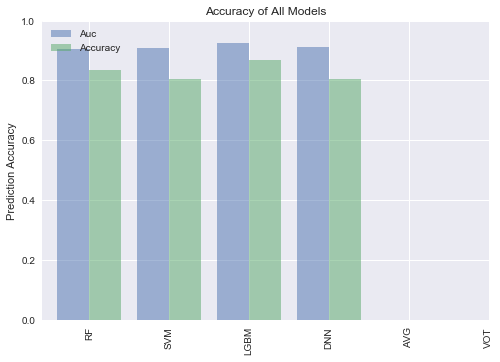

In [18]:
labels = df_scores.index
y_pos = np.arange(len(labels))
auc_vals = df_scores['AUC']
acc_vals = df_scores['Binary Accuracy']
plt.ylim(0,1)
plt.bar(y_pos, auc_vals, .4, alpha=0.5, label='Auc')
plt.bar(y_pos+.4, acc_vals, .4, alpha=0.5, label='Accuracy')
plt.xticks(y_pos+.2, labels,rotation='vertical')
plt.ylabel('Prediction Accuracy')
plt.title('Accuracy of All Models')
plt.legend()
plt.show()

## Random Forest Explainability

In [19]:
estimator = rf_model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [20]:
#code from https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename = 'tree.png')

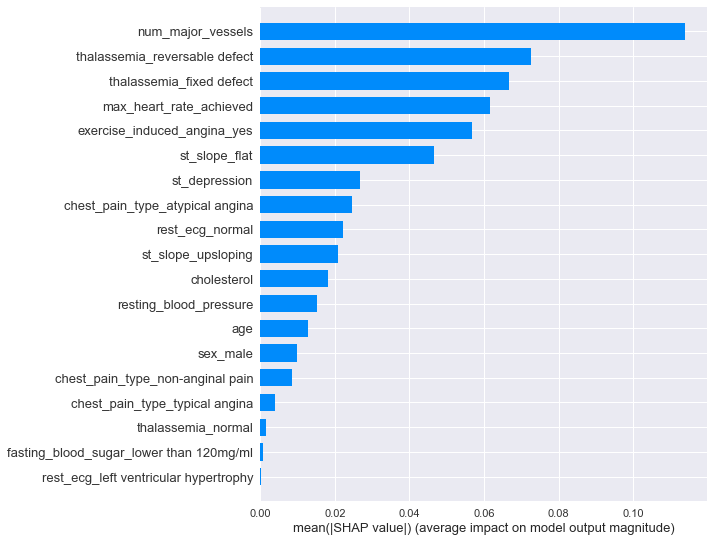

In [21]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")

In [22]:
perm = PermutationImportance(rf_model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

## LightGBM Explainability

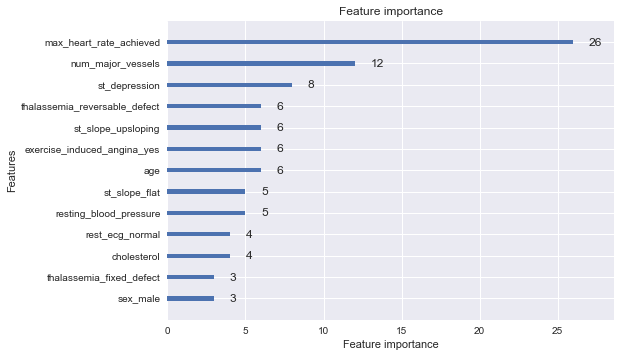

In [23]:
ax = lgb.plot_importance(gbm)
plt.show()

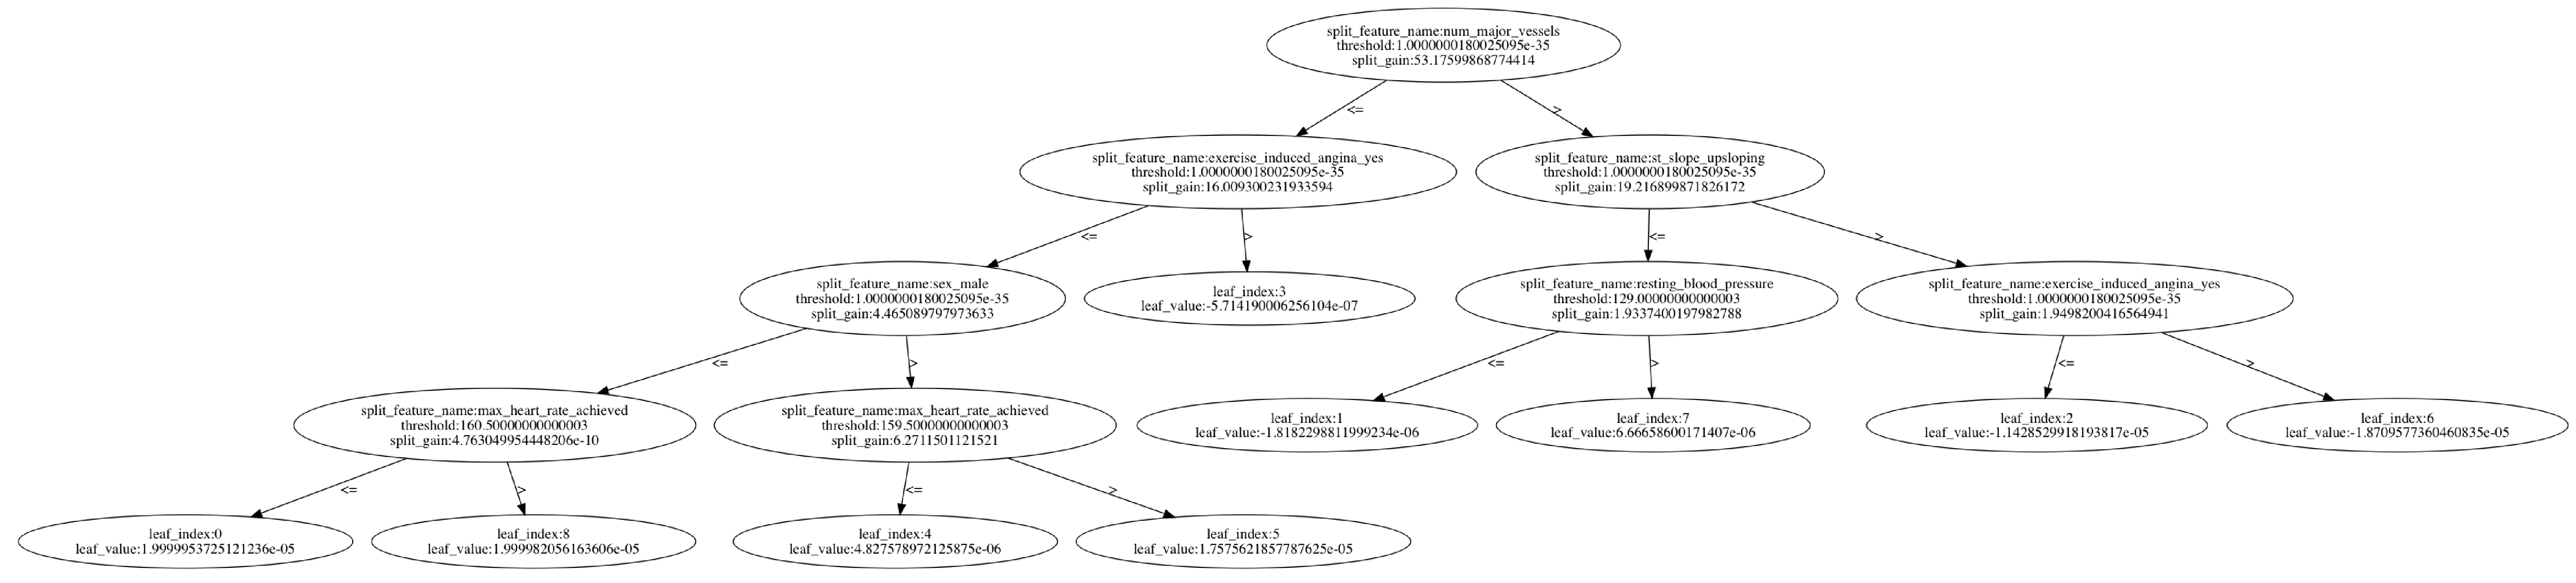

In [24]:
ax = lgb.plot_tree(gbm, tree_index=1, figsize=(100, 100), show_info=['split_gain'])
plt.show()

#graph = lgb.create_tree_digraph(gbm, tree_index=-1, name='Tree54')
#graph.render(view=True)

# Ensemble Aggregation

In [25]:
weights = [df_scores.loc[i]['Binary Accuracy'] * 100 for i in df_scores.index[:-2]]
weights = [weight/100 for weight in weights]

#Weight the mean using the success of each model
def weighted_avg(w,x,y,z):
    return mean([w*weights[0], x*weights[1], y*weights[2], z*weights[3]])

#Tally an even vote of each model
def vote(w,x,y,z):
    votes = 0
    for pred in w,x,y,z:
        if pred >= .5:
            votes+= 1
    return votes/4


In [26]:
#Create new predictions by calculating the weighted mean of all 4 models
avg_preds = [weighted_avg(w,x,y,z) for w,x,y,z in zip(rf_preds_prob,svm_preds_prob,gbm_preds,dnn_preds)]
vot_preds = [vote(w,x,y,z) for w,x,y,z in zip(rf_preds_prob,svm_preds_prob,gbm_preds,dnn_preds)]

#Calculate AUC and binary prediction accuracy of the weighted average
fpr, tpr, thresholds = roc_curve(y_test, avg_preds)
df_scores.loc['AVG']['AUC'] = auc(fpr, tpr)
avg_bi_preds = [1 if x>.5 else 0 for x in avg_preds]
df_scores.loc['AVG']['Binary Accuracy'] = sum([1 if x==y else 0 for x,y in zip(avg_bi_preds,y_test)])/len(y_test)

#Calculate AUC and binary prediction accuracy
fpr, tpr, thresholds = roc_curve(y_test, vot_preds)
df_scores.loc['VOT']['AUC'] = auc(fpr, tpr)
vot_bi_preds = [1 if x>.5 else 0 for x in vot_preds]
df_scores.loc['VOT']['Binary Accuracy'] = sum([1 if x==y else 0 for x,y in zip(vot_bi_preds,y_test)])/len(y_test)

In [27]:
df_scores.astype(float).round(3)

AUC  Binary Accuracy
RF    0.903            0.836
SVM   0.909            0.803
LGBM  0.923            0.869
DNN   0.911            0.803
AVG   0.921            0.836
VOT   0.914            0.852

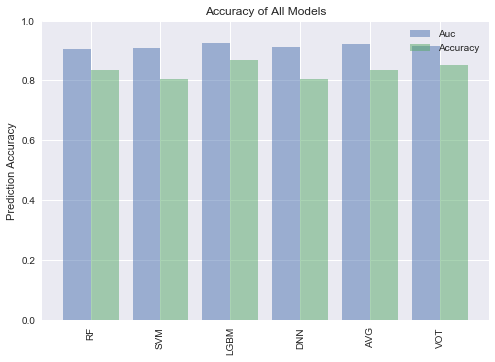

In [28]:
labels = df_scores.index
y_pos = np.arange(len(labels))
auc_vals = df_scores['AUC']
acc_vals = df_scores['Binary Accuracy']
plt.ylim(0,1)
plt.bar(y_pos, auc_vals, .4, alpha=0.5, label='Auc')
plt.bar(y_pos+.4, acc_vals, .4, alpha=0.5, label='Accuracy')
plt.xticks(y_pos+.2, labels,rotation='vertical')
plt.ylabel('Prediction Accuracy')
plt.title('Accuracy of All Models')
plt.legend()
plt.show()

<a id='section5'></a>